In [1]:
import pickle
import sys

import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from PIL import Image
from skimage.transform import rescale, resize, rotate
from skimage.color import gray2rgb, rgb2gray
from skimage import transform, filters, exposure

from tensorflow.contrib.layers import flatten

from tensorflow.examples.tutorials.mnist import input_data


%matplotlib inline

In [46]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        #mean = tf.reduce_mean(var)
        #tf.summary.scalar('mean', mean)
        #with tf.name_scope('stddev'):
        #    stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        #    tf.summary.scalar('stddev', stddev)
        #tf.summary.scalar('max', tf.reduce_max(var))
        #tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


In [27]:
#from network import Network

class LeNetClassifier(Network):

    def __init__(self, params, images):
        super(LeNetClassifier, self).__init__(params)
        x = images

        with tf.variable_scope('lenet') as scope:
            # 32 x 32 x 1 --> 28 x 28 x 6
            output = self._conv_block(x, output_maps=6,
                                    filter_size=5, stride=1, lr_mult=1.0,
                                    scope='conv_block1', restore=False)
            # relu
            output = self._nonlinearity(output)

            # MAX POOL 28x28x6 -> 14x14x6
            output = self._pool_layer(output, filter_size=2, stride=2, func='max', scope='pool1')

            # 14x14x6 -> 10x10x16
            output = self._conv_block(output, output_maps=16,
                                    filter_size=5, stride=1, lr_mult=1.0,
                                    scope='conv_block2', restore=False)

            # relu
            output = self._nonlinearity(output)

            # MAX POOL 10x10x16 --> 5x5x16
            output = self._pool_layer(output, filter_size=2, stride=2, func='max', scope='pool2')
            # fc1
            output = self._full_block(output, output_maps=120, features=None,
                                    weight_decay=0.0, lr_mult=1.0,
                                    scope='full_block1', restore=False)
            # relu
            #output = self._nonlinearity(output)

            # fc2
            output = self._full_block(output, output_maps=84, features=None,
                                    weight_decay=0.0, lr_mult=1.0,
                                    scope='full_block2', restore=False)

            # relu
            #output = self._nonlinearity(output)            
            
            output = self._last_block(output, features=None, lr_mult=1.0,
                                    scope='last_block', restore=False)
            self._output = output
    
    def getlogits(self):
        return self._output

In [47]:
#from network import Network

class LeNet2Classifier(Network):

    def __init__(self, params, images):
        super(LeNet2Classifier, self).__init__(params)
        x = images

        with tf.variable_scope('lenet2') as scope:
            ## CONV1
            # 32 x 32 x 1 --> 28 x 28 x 48
            output = self._conv_block(x, output_maps=48,
                                    filter_size=5, stride=1, lr_mult=1.0,
                                    scope='conv_block1', restore=False)
            # relu
            output = self._nonlinearity(output)
            # MAX POOL 28x28x48 -> 14x14x48
            output = self._pool_layer(output, filter_size=2, stride=2, func='max', scope='pool1')

            ## CONV2
            # 14x14x48 -> 10x10x96
            output = self._conv_block(output, output_maps=96,
                                    filter_size=5, stride=1, lr_mult=1.0,
                                    scope='conv_block2', restore=False)

            # relu
            output = self._nonlinearity(output)
            # MAX POOL 10x10x96 --> 5x5x96
            output = self._pool_layer(output, filter_size=2, stride=2, func='max', scope='pool2')

            ## CONV3
            # 5x5x96 -> 3x3x172
            output = self._conv_block(output, output_maps=172,
                                    filter_size=3, stride=1, lr_mult=1.0,
                                    scope='conv_block3', restore=False)

            # relu
            output = self._nonlinearity(output)
            # MAX POOL 3x3x172 --> 2x2x172
            output = self._pool_layer(output, filter_size=2, stride=2, func='max', scope='pool2')
            
            # fc1
            output = self._full_block(output, output_maps=688, features=None,
                                    weight_decay=0.0, lr_mult=1.0,
                                    scope='full_block1', restore=False)
            # relu
            #output = self._nonlinearity(output)

            # fc2
            output = self._full_block(output, output_maps=84, features=None,
                                    weight_decay=0.0, lr_mult=1.0,
                                    scope='full_block2', restore=False)

            # relu
            #output = self._nonlinearity(output)            
            
            output = self._last_block(output, features=None, lr_mult=1.0,
                                    scope='last_block', restore=False)
            self._output = output
    
    def getlogits(self):
        return self._output

In [48]:
tf.reset_default_graph()
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

x = tf.placeholder(tf.float32, [None, 28,28,1])
resized = tf.image.resize_images(x, (32, 32))
y_ = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)
params={}
params["classes_num"] = 10
params["is_train"] = True
params["decay"] = 0.1

LENET = LeNet2Classifier(params,x)
logits = LENET.getlogits()

with tf.variable_scope("cost") as scope:
    #cost = tf.reduce_sum(tf.pow(pred_y - y_, 2))/(2*n_samples)
    softmax = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logits)
    cost = tf.reduce_mean(softmax)

with tf.variable_scope("train") as scope:

    #train_op = tf.train.AdamOptimizer(1e-4).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    train_op = optimizer.minimize( cost )

with tf.variable_scope("acc") as scope:
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar('accuracy', accuracy)

baseDir = "/Users/donchan/Documents/UdaCity/SelfCar/CarND-Traffic-Sign-Classifier-Project/tmp"
    
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(os.path.join(baseDir,"summary"), sess.graph)

with tf.Session() as sess:

    init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
    sess.run(init_op)
    saver = tf.train.Saver()

    for it in range(200):

        data,labels = mnist.train.next_batch(32)
        sh = data.shape
        data = data.reshape(sh[0],28,28,1 )
        #data = new_data.reshape( new_data.shape + (1,)  )            
        #print(data.shape)
        feeds = {x:data, y_:labels}

        train_op.run(feed_dict = feeds)
        summary_str = sess.run(merged,feed_dict=feeds)
        #summary_str = sess.run(merged_summary_op, feed_dict=feeds)

        if it % 10 == 0:
            feeds = {x:data, y_:labels}
            acc, cost_ = sess.run([accuracy,cost],feed_dict=feeds)
            print("step %d, accuracy:%.4f cost:%.4f"%(it,acc,cost_))
            train_writer.add_summary(summary_str, it)
    
    savefile = os.path.join(baseDir,"mnist")
    save_path = saver.save(sess,savefile, global_step=it)
    print("save is done.", save_path)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, accuracy:0.2812 cost:2.2274
step 10, accuracy:0.6562 cost:1.8962
step 20, accuracy:0.7500 cost:1.5692
step 30, accuracy:0.7188 cost:1.3338
step 40, accuracy:0.8438 cost:1.1871
step 50, accuracy:1.0000 cost:0.8715
step 60, accuracy:0.9688 cost:0.7458
step 70, accuracy:0.9375 cost:0.6919
step 80, accuracy:0.9688 cost:0.3998
step 90, accuracy:0.8750 cost:0.5529
step 100, accuracy:0.8750 cost:0.6293
step 110, accuracy:1.0000 cost:0.2222
step 120, accuracy:0.9062 cost:0.4786
step 130, accuracy:1.0000 cost:0.2202
step 140, accuracy:1.0000 cost:0.1938
step 150, accuracy:0.9688 cost:0.2243
step 160, accuracy:1.0000 cost:0.1088
step 170, accuracy:1.0000 cost:0.1056
step 180, accuracy:1.0000 cost:0.1363
step 190, accuracy:1.0000 cost:0.1683
save is done. /Users/donchan/Documents/UdaCity/SelfCar/Ca

In [12]:
var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"lenet")


In [20]:
op = sess.graph.get_operations()
[m.values() for m in op]

[(<tf.Tensor 'Placeholder:0' shape=(?, 28, 28, 1) dtype=float32>,),
 (<tf.Tensor 'size:0' shape=(2,) dtype=int32>,),
 (<tf.Tensor 'ResizeBilinear:0' shape=(?, 32, 32, 1) dtype=float32>,),
 (<tf.Tensor 'Placeholder_1:0' shape=(?, 10) dtype=float32>,),
 (<tf.Tensor 'Placeholder_2:0' shape=<unknown> dtype=float32>,),
 (<tf.Tensor 'lenet/conv_block1/conv/weights:0' shape=(5, 5, 1, 6) dtype=float32_ref>,),
 (<tf.Tensor 'lenet/conv_block1/conv/weights/Initializer/truncated_normal/shape:0' shape=(4,) dtype=int32>,),
 (<tf.Tensor 'lenet/conv_block1/conv/weights/Initializer/truncated_normal/mean:0' shape=() dtype=float32>,),
 (<tf.Tensor 'lenet/conv_block1/conv/weights/Initializer/truncated_normal/stddev:0' shape=() dtype=float32>,),
 (<tf.Tensor 'lenet/conv_block1/conv/weights/Initializer/truncated_normal/TruncatedNormal:0' shape=(5, 5, 1, 6) dtype=float32>,),
 (<tf.Tensor 'lenet/conv_block1/conv/weights/Initializer/truncated_normal/mul:0' shape=(5, 5, 1, 6) dtype=float32>,),
 (<tf.Tensor 'len

In [49]:
def loadlabelnamelist():

    signnames = "signnames.csv"
    df_signname = pd.read_csv(signnames)

    signname_dict = {}
    for k,v in zip(df_signname["ClassId"].values,df_signname["SignName"].values):
        signname_dict[k] = v

    return signname_dict

def loadDownloadImage():

    imageProcCls = ImageProces()
    download_images = {}

    downloadDir = "./DownloadsSign"
    files = os.listdir(downloadDir)
    for name in files:
        filename = name.split(".")
        if filename[-1] != "jpg" and filename[-1] != "png":
            continue
        print(name)
        image = cv2.imread( os.path.join(downloadDir,name) )
        image = cv2.resize(image,(32,32))
        
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)    
        image = imageProcCls.getGrayScale(image) / 255.

        download_images[filename[0]] = image

    return download_images 

In [51]:

class ImageAugmentationClass(object):

    def __init__(self,test=False):
        self.test = test

    def choiceAugmentation(self,img):

        self.choice_flag = np.random.randint(0, 2, [1, 10]).astype('bool')[0]

        img = self.horizontal_flip(img)
        img = self.horizontal_flip(img)
        return img

    def horizontal_flip(self, image):
        if self.choice_flag[0]:
            image = image[:,::-1,:]
        return image
    def vertical_flip(self, image):
        if self.choice_flag[1]:
            image = image[::-1,:,:]
        return image


    def transform_image(self,img,ang_range,shear_range,trans_range,brightness=0):

        #Advantage function is prepared to show the picture of the same sign from different angles.
        #I have used blended function with using openCV Affine translations and numpy,
        # rotations, translations and shearing parameters should be used.
        # Rotation
        ang_rot = np.random.uniform(ang_range)-ang_range/2
        rows,cols,ch = img.shape
        Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

        # Translation
        tr_x = trans_range*np.random.uniform()-trans_range/2
        tr_y = trans_range*np.random.uniform()-trans_range/2
        Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

        # Shear
        pts1 = np.float32([[5,5],[20,5],[5,20]])

        pt1 = 5+shear_range*np.random.uniform()-shear_range/2
        pt2 = 20+shear_range*np.random.uniform()-shear_range/2

        # Brightness

        pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

        shear_M = cv2.getAffineTransform(pts1,pts2)

        img = cv2.warpAffine(img,Rot_M,(cols,rows))
        img = cv2.warpAffine(img,Trans_M,(cols,rows))
        img = cv2.warpAffine(img,shear_M,(cols,rows))

        #if brightness == 1:
        #  img = augment_brightness_camera_images(img)

        return img


    def random_crop(self,image, crop_size=(32,32)):

        h, w, _ = image.shape
        # determine top left from crop size
        top = np.random.randint(0, h - crop_size[0])
        left = np.random.randint(0, w - crop_size[1])

        # from top, left, size should be calculated plus random (0-32)
        bottom = top + crop_size[0]
        right = left + crop_size[1]

        image = image[top:bottom, left:right, :]
        return image



class ImageProces(object):

    def __init__(self):

        self.imgAugCls = ImageAugmentationClass()

    def data_initialization(self):

        data = self.load_data()
        self.X_train, self.y_train = data['features'], data['labels']
        print("[ImageProcess] train features and label..",self.X_train.shape,self.y_train.shape)

        self.n_train = self.X_train.shape[0]
        self.image_shape = self.X_train.shape[1:2]
        self.n_classes = len(set(self.y_train))

        #self.imagePreprocess()

    def load_data(self):

        training_file = "train.p"
        validation_file="valid.p"
        testing_file = "test.p"

        with open(training_file, mode='rb') as f:
            train = pickle.load(f)

            return train
        print("load train data - ImageProces...")

    def getGrayScale(self,img):

        # About YCrCb
        # The YCrCb color space is derived from the RGB color space and has the following three compoenents.

        # Y – Luminance or Luma component obtained from RGB after gamma correction.
        # Cr = R – Y ( how far is the red component from Luma ).
        # Cb = B – Y ( how far is the blue component from Luma ).

        # This color space has the following properties.

        # Separates the luminance and chrominance components into different channels.
        # Mostly used in compression ( of Cr and Cb components ) for TV Transmission.
        # Device dependent.

        # Observations

        # Similar observations as LAB can be made for Intensity and color components with regard to Illumination changes.
        # Perceptual difference between Red and Orange is less even in the outdoor image as compared to LAB.
        # White has undergone change in all 3 components.

        YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        return np.resize(YCrCb[:,:,0], (32,32,1))

    def rgb2gray(self,rgb):

        r, g, b = rgb[:, :,:,0], rgb[:, :,:,1], rgb[:,:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

        return gray

    def imagePreprocess(self):

        ts, imgs_per_sign   = np.unique(self.y_train, return_counts=True)
        avg_per_sign        = np.ceil(np.mean(imgs_per_sign)).astype('uint32')

        print(ts)
        print(imgs_per_sign)
        print("Average Counts per each TrafficSign...", avg_per_sign)

        separated_data = []
        for label_index in ts:
            images_in_this_sign = self.X_train[self.y_train == label_index, ...]
            separated_data.append(images_in_this_sign)

        new_effect_cnt = list( map(lambda x: (3.7 * (avg_per_sign  / x) ).astype(np.int32)  , (imgs_per_sign)  ) )

        whole_aug_image_dict = {}
        new_y_train = []

        for idx, (loop_cnt, sign_images) in enumerate( zip(new_effect_cnt, separated_data)):
            print("label:%d  loop_cnt:%d new augmentation images.:%d " % (ts[idx], loop_cnt, (loop_cnt * imgs_per_sign[idx]))  )
            print("original image shape", sign_images.shape)
            separate_aug_image = sign_images.copy()
        
            for cnt in range(loop_cnt):
                X_aug_img = list( map( lambda image: self.imgAugCls.transform_image( image,30,5,5  ) , sign_images[:]  ) )
                X_aug_img = np.array(X_aug_img)

                separate_aug_image = np.vstack( (separate_aug_image,X_aug_img))

            # save whole images per label into dict
            whole_aug_image_dict[ ts[idx]  ] = separate_aug_image

            len_separate_aug_image = separate_aug_image.shape[0]
            extend_labels = np.full( len_separate_aug_image,  ts[idx]   )
            new_y_train.extend(extend_labels)            
            print("final shape (augment image + original image) per label" , separate_aug_image.shape  )

        ts, imgs_per_sign   = np.unique(new_y_train, return_counts=True)
        print("-"*30)
        print(" new y_train (label) count ..")
        print(ts)
        print(imgs_per_sign)

        all_aug_images = whole_aug_image_dict[ 0  ] # get first label image data
        for k,v in whole_aug_image_dict.items():
            if k == 0: # skip label 0, because it has already saved 
                continue
            all_aug_images = np.vstack( (all_aug_images, v) )

        assert(len(new_y_train) == all_aug_images.shape[0]  )

        print("new image data shape after augmentation." , all_aug_images.shape[0] )
        return all_aug_images, np.array( new_y_train )

    def displayImage(self,images):

        gs1 = gridspec.GridSpec(10, 10)
        gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
        plt.figure(figsize=(10,10))
        for i in range(100):
            ax1 = plt.subplot(gs1[i])
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.set_aspect('equal')
            #img = transform_image(image,20,10,5,brightness=1)

            plt.subplot(10,10,i+1)
            plt.imshow(images[i])
            plt.axis('off')

        plt.show()

    def displayImageDistribution(self,images):

        gs1 = gridspec.GridSpec(10, 10)
        gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
        plt.figure(figsize=(10,10))
        for i in range(100):
            ax1 = plt.subplot(gs1[i])
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.set_aspect('equal')
            #img = transform_image(image,20,10,5,brightness=1)

            plt.subplot(10,10,i+1)
            sns.distplot(images[i].ravel() )
            plt.axis('off')

        plt.show()

    def saveImagesPickle(self,new_train_data):

        bytes_out = pickle.dumps(new_train_data)
        max_bytes = 2**31 - 1
        n_bytes   = sys.getsizeof(bytes_out)

        output_path   = 'train_aug.p'
        with open(output_path, 'wb') as f:
            for idx in range(0, n_bytes, max_bytes):
                f.write(bytes_out[idx:idx+max_bytes])


In [52]:
dl_images = loadDownloadImage()

yield1_13.jpg
stop3_14.jpg
roundabout_40.png
ChildrenCrossing_28.jpg
roadwork_25.jpg
roadwork2_25.jpg
Orstafel.png
keep_right_38.jpg
Yield_13.jpg
speedlm70a_4.jpg
68965645-german-road-sign-traffic-signals.jpg
Slippy_23.jpg
german_1.jpg
stop2_14.jpg
img5.jpg
speedlm20a_0.jpg
yield2_13.jpg
speedlm30a_1.jpg
AheadOnly_35.jpg
speedlm30c_1.jpg
roadwork3_25.jpg
turnleftAhead_34.jpg
PriorityLoad_12.jpg
speedlm30_1.jpg
NoEntry_17.jpg
speedlm30b_1.jpg
stop_14.jpg
465921887.jpg


In [57]:
np.array(  [v for k,v in dl_images.items() ] ).shape

(28, 32, 32, 1)

file length.. 30


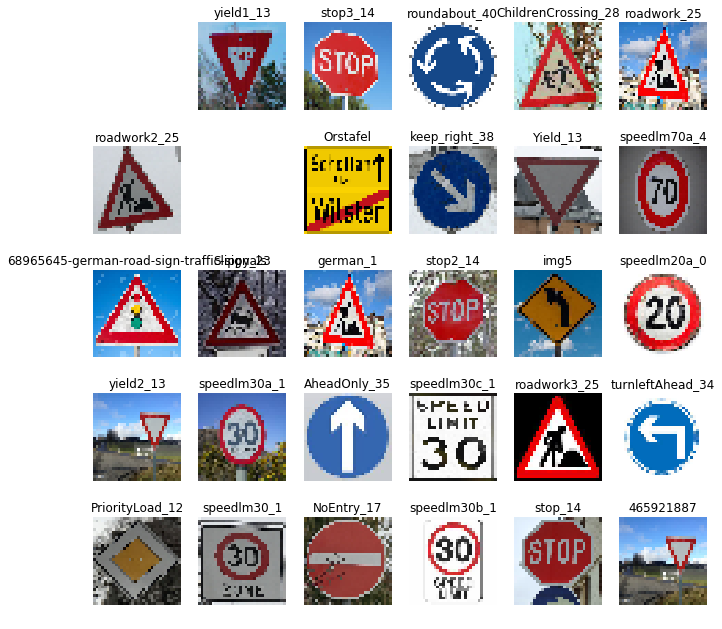

In [74]:
gs1 = gridspec.GridSpec(5, 6)
gs1.update(wspace=0.01, hspace=0.1) # set the spacing between axes.
plt.figure(figsize=(11,11))

downloadDir = "./DownloadsSign"
files = os.listdir(downloadDir)
print("file length..",len(files))
for i, name in enumerate(files):
    filename = name.split(".")
    if filename[-1] != "jpg" and filename[-1] != "png":
        continue
    #print(name)
    image = cv2.imread( os.path.join(downloadDir,name) )
    image = cv2.resize(image,(32,32))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)    

    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    #ax1.set_title( name )
    ax1.set_aspect('equal')
    #img = transform_image(image,20,10,5,brightness=1)

    plt.subplot(5,6,i+1)
    plt.title(filename[0])
    plt.imshow(image)
    plt.axis('off')

plt.show()


In [15]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 28,28,1])
resized = tf.image.resize_images(x, (32, 32))

y_ = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)


logits = LeNet(resized,10)

with tf.variable_scope("cost") as scope:
    #cost = tf.reduce_sum(tf.pow(pred_y - y_, 2))/(2*n_samples)
    softmax = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logits)
    cost = tf.reduce_mean(softmax)

with tf.variable_scope("train") as scope:

    #train_op = tf.train.AdamOptimizer(1e-4).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    train_op = optimizer.minimize( cost )

with tf.variable_scope("acc") as scope:
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

baseDir = "/Users/donchan/Documents/UdaCity/SelfCar/CarND-Traffic-Sign-Classifier-Project/tmp"
    
with tf.Session() as sess:

    init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
    sess.run(init_op)
    saver = tf.train.Saver()

    for it in range(10):

        data,labels = mnist.train.next_batch(32)
        sh = data.shape
        data = data.reshape(sh[0],28,28,1 )
        #data = new_data.reshape( new_data.shape + (1,)  )            
        #print(data.shape)
        feeds = {x:data, y_:labels}

        train_op.run(feed_dict=feeds)
        #summary_str = sess.run(merged_summary_op, feed_dict=feeds)
        #summary_writer.add_summary(summary_str, it)

        if it % 10 == 0:
            feeds = {x:data, y_:labels}
            acc, cost_ = sess.run([accuracy,cost],feed_dict=feeds)
            print("step %d, accuracy:%.4f cost:%.4f"%(it,acc,cost_))

    savefile = os.path.join(baseDir,"mnist")
    save_path = saver.save(sess,savefile, global_step=it)
    print("save is done.", save_path)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, accuracy:0.3125 cost:2.2540
save is done. /Users/donchan/Documents/UdaCity/SelfCar/CarND-Traffic-Sign-Classifier-Project/tmp/mnist-9


In [37]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

with tf.Session() as sess:

    init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
    sess.run(init_op)
    save_path = os.path.join(baseDir,"mnist-199")
    saver.restore(sess,save_path )
    

    for it in range(30):

        data,labels = mnist.train.next_batch(32)
        sh = data.shape
        data = data.reshape(sh[0],28,28,1 )
        #data = new_data.reshape( new_data.shape + (1,)  )            
        #print(data.shape)
        feeds = {x:data, y_:labels}

        train_op.run(feed_dict=feeds)
        #summary_str = sess.run(merged_summary_op, feed_dict=feeds)
        #summary_writer.add_summary(summary_str, it)

        if it % 10 == 0:
            feeds = {x:data, y_:labels}
            acc, cost_ = sess.run([accuracy,cost],feed_dict=feeds)
            print("step %d, accuracy:%.4f cost:%.4f"%(it,acc,cost_))


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, accuracy:0.9688 cost:0.1527
step 10, accuracy:0.9688 cost:0.1481
step 20, accuracy:1.0000 cost:0.0840


In [2]:
#  Copyright 2016-present Sergey Demyanov. All Rights Reserved.
#
#  Contact: my_name@my_sirname.net
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
# =============================================================================

import tensorflow as tf

class Network(object):

    STDDEV = 1e-4
    BN_EPS = 1e-5

    INIT_SCOPE = 'init_scope'
    LOSSES_NAME = 'losses'
    TRAINING_PREFIX = 'training'
    TESTING_PREFIX = 'testing'

    def __init__(self, params):
        #self.batch_size = self.shape(images, 0)
        self.is_train = params['is_train']
        self.decay = params['decay']
        self.classes_num = params['classes_num']
        if self.is_train:
            self._prefix = Network.TRAINING_PREFIX
        else:
            self._prefix = Network.TESTING_PREFIX
        self.lr_multipliers = {}
        self.rest_names = {}
        self._output = None # redefine it in a derived class

    @staticmethod
    def shape(output, dim=None):
        shape = output.get_shape().as_list()
        if dim is not None:
            return shape[dim]
        return shape

    @classmethod
    def _output_elem(cls, output):
        shape = cls.shape(output)
        elem = 1
        for i in range(1, len(shape)):
            elem *= shape[i]
        return elem

    @staticmethod
    def _append(restore, appendix):
        if (restore == False or restore == True):
            return restore
        return restore + '/' + appendix

    @staticmethod
    def _set_weight_decay(var, weight_decay):
        if (weight_decay is not None) and (weight_decay > 0):
            weight_decay = tf.mul(tf.nn.l2_loss(var), weight_decay) #, name=var.name)
            tf.add_to_collection(Network.LOSSES_NAME, weight_decay)

    def _set_lr_mult(self, var, lr_mult):
        self.lr_multipliers[var.op.name] = lr_mult

    def _set_restoring(self, var, restore=True):
        if restore == False:
            return
        if restore == True:
            restore = var.op.name
        self.rest_names[restore] = var
        #print("%s: %s" %(var.op.name, restore))

    def _variable(self, name, shape, initializer,
                weight_decay, lr_mult, restore=True):
        is_trainable = (lr_mult > 0)
        var = tf.get_variable(name=name, shape=shape,
                              initializer=initializer, trainable=is_trainable)
        
        variable_summaries(var)

        
        if is_trainable:
            Network._set_weight_decay(var, weight_decay)
        self._set_lr_mult(var, lr_mult)

        self._set_restoring(var, restore)
        return var

    def _normal_variable(self, name, shape, stddev,
                       weight_decay, lr_mult, restore=True):
        initializer = tf.truncated_normal_initializer(stddev=stddev)
        return self._variable(name, shape, initializer,
                              weight_decay, lr_mult, restore)

    def _constant_variable(self, name, shape, value,
                         weight_decay, lr_mult, restore=True):
        initializer = tf.constant_initializer(value)
        return self._variable(name, shape, initializer,
                              weight_decay, lr_mult, restore)

    def _xavier_variable(self, name, shape, value,
                         weight_decay, lr_mult, restore=True):
        initializer = tf.constant_initializer(value)
        initializer=tf.contrib.layers.xavier_initializer()

        return self._variable(name, shape, initializer,
                              weight_decay, lr_mult, restore)
    ### BASIC LAYERS ###

    def _activation_summary(self, output, scope='summary'):
        return
        # no summary for test network
        #if not self.is_train:
        #  return
        #with tf.variable_scope(scope):
        #  tensor_name = output.op.name
        #  tf.histogram_summary('activations/' + tensor_name, output)
        #  zero_fraction = tf.nn.zero_fraction(output)
        #  tf.scalar_summary('sparsity/' + tensor_name, zero_fraction)


    def _nonlinearity(self, output):
        output = tf.nn.relu(output, name='relu')
        return output

    def _batch_norm(self, output,
                  lr_mult=1.0, scope='bn', restore=True):
        with tf.variable_scope(scope):
            shape = Network.shape(output)
            # we don't squeeze only the last dimension, i.e. feature maps
            squeeze_dims = range(len(shape)-1)
            input_maps = shape[-1]
            batch_mean, batch_var = tf.nn.moments(output, squeeze_dims, name='moments')
            ema = tf.train.ExponentialMovingAverage(decay=self.decay)
            ema_apply_op = ema.apply([batch_mean, batch_var])
            # Needed for partial restoration from an existing model
            self._set_restoring(ema.average(batch_mean),
                              Network._append(restore, 'moving_mean'))
            self._set_restoring(ema.average(batch_var),
                              Network._append(restore, 'moving_variance'))
            if self.is_train: # and lr_mult > 0):
                with tf.control_dependencies([ema_apply_op]):
                    mean, var = tf.identity(batch_mean), tf.identity(batch_var)
            else:
                #mean, var = batch_mean, batch_var
                mean, var = ema.average(batch_mean), ema.average(batch_var)

            beta = self._constant_variable('beta', [input_maps], 0.0, 0.0,
                                         lr_mult, Network._append(restore, 'beta'))
            gamma = self._constant_variable('gamma', [input_maps], 1.0, 0.0,
                                          lr_mult, Network._append(restore, 'gamma'))
            output = tf.nn.batch_normalization(output, mean, var, beta, gamma, Network.BN_EPS)
            return output


    def _pool_layer(self, output, filter_size=3, stride=2, func='max', scope='pool'):
        with tf.variable_scope(scope):
            ksize = [1, filter_size, filter_size, 1]
            strides = [1, stride, stride, 1]
            if (func=='max'):
                output = tf.nn.max_pool(output, ksize=ksize,
                                        strides=strides,  padding='SAME')
            elif (func=='avg'):
                output = tf.nn.avg_pool(output, ksize=ksize,
                                        strides=strides,  padding='SAME')
            else:
                assert False, 'unsupported pooling function'
            return output


    def _conv_layer(self, output, output_maps, filter_size, stride,
                  weight_decay=0.0, lr_mult=1.0,
                  scope='conv', restore=True):
        input_maps = Network.shape(output, 3)
        filter_shape = [filter_size, filter_size, input_maps, output_maps]
        with tf.variable_scope(scope):
            kernel = self._normal_variable('weights', filter_shape, Network.STDDEV,
                                         weight_decay, lr_mult,
                                         Network._append(restore, 'weights'))
            output = tf.nn.conv2d(output, kernel, [1, stride, stride, 1], padding='SAME')
            # No biases in resnet convolutional layers
            """
            biases = self._constant_variable('biases', [output_maps], 0.0,
                                           weight_decay, lr_mult,
                                           Network._append(restore, 'biases'))
            output = tf.nn.bias_add(output, biases)
            """
            return output


    def _full_layer(self, output, output_maps, features=None,
                  weight_decay=0.0, lr_mult=1.0,
                  scope='full', restore=True):
        input_maps = Network._output_elem(output)
        with tf.variable_scope(scope):
            output = tf.reshape(output, [-1, input_maps])
            if (features is not None):
                output = tf.concat(concat_dim=1, values=[output, features])
                input_maps += Network._output_elem(features)

            weights = self._normal_variable('weights', [input_maps, output_maps],
                                          1.0/input_maps, weight_decay, lr_mult,
                                          Network._append(restore, 'weights'))
            output = tf.matmul(output, weights)
            biases = self._constant_variable('biases', [output_maps], 0.0,
                                           weight_decay, lr_mult,
                                           Network._append(restore,'biases'))
            output = tf.add(output, biases)
            return output


    ### COMPOSED LAYERS ###

    def _full_pool(self, output, scope='full_pool'):
        input_dims = Network.shape(output)
        if (len(input_dims) == 2):
            return
        assert len(input_dims) == 4
        # make sure that the input is squared
        assert input_dims[1] == input_dims[2]
        with tf.variable_scope(scope):
            
            map_size = input_dims[1]
            if (map_size > 1):
                output = self._pool_layer(output, filter_size=map_size,
                                      stride=map_size, func='avg')
            output = tf.reshape(output, [-1, input_dims[3]])
            return output

    def _conv_block(self, output, output_maps,
                  filter_size=3, stride=1,
                  weight_decay=0.0, lr_mult=1.0,
                  scope='conv_block', restore=True):
        with tf.variable_scope(scope):
            output = self._conv_layer(output, output_maps, filter_size, stride,
                                    weight_decay, lr_mult, restore=restore)
            output = self._batch_norm(output, lr_mult, restore=restore)
            output = self._nonlinearity(output)
            self._activation_summary(output)
            return output

    def _resn_block(self, output, inside_maps,
                  output_maps=None, stride=1,
                  weight_decay=0.0, lr_mult=1.0,
                  scope='resn_block', restore=True):
        with tf.variable_scope(scope):
            residual = tf.identity(output)
            input_maps = Network.shape(output, 3)
            if not output_maps:
                output_maps = input_maps
            if (output_maps != input_maps or stride != 1):
                with tf.variable_scope('projection'):
                    output = self._conv_layer(output, output_maps, 1, stride,
                                            weight_decay, lr_mult,
                                            restore=Network._append(restore, 'shortcut'))
                    output = self._batch_norm(output, lr_mult,
                                            restore=Network._append(restore, 'shortcut'))

            residual = self._conv_block(residual, inside_maps, 1, stride,
                                    weight_decay, lr_mult, scope='in',
                                    restore=Network._append(restore, 'a'))
            residual = self._conv_block(residual, inside_maps, 3, 1,
                                    weight_decay, lr_mult, scope='middle',
                                    restore=Network._append(restore, 'b'))
            residual = self._conv_block(residual, output_maps, 1, 1,
                                    weight_decay, lr_mult, scope='out',
                                    restore=Network._append(restore, 'c'))
            output += residual
            self._activation_summary(output)
            return output


    def _full_block(self, output, output_maps, features=None,
                  weight_decay=0.0, lr_mult=1.0,
                  scope='full_block', restore=True):
        with tf.variable_scope(scope):
            output = self._full_layer(output, output_maps, features,
                                    weight_decay, lr_mult, restore=restore)
            #output = self._batch_norm(output, lr_mult, restore=restore)
            output = self._nonlinearity(output)
            self._activation_summary(output)
            return output

    def _last_block(self, output, features=None,
                  weight_decay=0.0, lr_mult=1.0,
                  scope='last_block', restore=True):
        with tf.variable_scope(scope):
            output = self._full_layer(output, self.classes_num, features,
                                    weight_decay, lr_mult, restore=restore)
            # No batch_norm in resnet for the fc-layer
            # output = self._batch_norm(output, lr_mult, restore, restscope=restscope)
            # Last layer does not have nonlinearity!
            self._activation_summary(output)
            return output

    def probs(self):
        return tf.nn.softmax(self._output)


    def cross_entropy_losses(self, labels):
        # labels must be already tf.int64
        with tf.variable_scope('cross_entropy_losses/' + self._prefix):
            return tf.nn.sparse_softmax_cross_entropy_with_logits(
                self._output, labels, name='cross_entropy_per_example'
            )


    def losses(self, labels):
        cross_entropy = self.cross_entropy_losses(labels)
        with tf.variable_scope('total_loss/' + self._prefix):
            cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
            tf.add_to_collection(Network.LOSSES_NAME, cross_entropy_mean)
            total_loss = tf.add_n(tf.get_collection(Network.LOSSES_NAME))
            # We will be tracking training error manually as well until they fix ema
            # self._add_loss_summaries(total_loss)
            return cross_entropy, total_loss

    """
    def output(self):
    return self._output
    """


In [ ]:
#
import numpy as np
import tensorflow as tf
import pandas as pd


from collections import deque

INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.1  #
EXPLORATION_STEPS = 1000000  #

FRAME_WIDTH = 2
FRAME_HEIGHT = 2
#STATE_LENGTH  = 3

NUM_HIDDEN1=128
NUM_HIDDEN2=128

NUM_INPUT=4
NUM_OUTPUT=5

class AgentClass(object):

    def __init__(self, num_actions,STATE_LENGTH=3):

        self.num_actions = num_actions  #
        self.epsilon = INITIAL_EPSILON  # g
        self.epsilon_step = (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORATION_STEPS  #
        self.time_step = 0
        self.repeated_action = 0

        self.STATE_LENGTH = STATE_LENGTH
        self.x = tf.placeholder( "float", [None, FRAME_WIDTH, FRAME_HEIGHT] )
        print("** AgentClass x: ",self.x.get_shape().as_list())

        self.y_q_values = self.build_network_dense("Q",NUM_INPUT,NUM_HIDDEN1,NUM_HIDDEN2,NUM_OUTPUT)

        self.sess = tf.Session()
        init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
        self.sess.run(init_op)
        #self.saver = tf.train.Saver()



        self.train_loop_counter = 0

    def update_summary(self):

        episode_reward_mean = tf.Variable(.0)
        tf.summary.scalar('episode_reward_mean', episode_reward_mean)

        training_loss_mean = tf.Variable(.0)
        tf.summary.scalar('training_loss_mean', training_loss_mean)

        maxq_mean = tf.Variable(.0)
        tf.summary.scalar('maxq_mean', maxq_mean)

        summary_vars = [episode_reward_mean,training_loss_mean,maxq_mean]
        summary_ph = [tf.placeholder(tf.float32) for _ in summary_vars]
        summary_op = [summary_vars[i].assign(summary_ph[i]) for i in range(len(summary_vars)) ]

        return summary_vars, summary_ph, summary_op

    def epsilon_update(self):
        if self.epsilon > FINAL_EPSILON:
            self.epsilon -= self.epsilon_step
        return self.epsilon

    def copyTargetQNetwork(self):
        self.sess.run(self.copyTargetQNetworkOperation)

    def build_Q(self,STATE_LENGTH):
        # Q Network
        y_conv, q_network_values = self.build_network(main_name="Qnet",STATE_LENGTH=3)
        return y_conv, q_network_values

    def build_target(self,STATE_LENGTH):
        #Target Network
        y_target_conv, target_q_values = self.build_network(main_name="target",STATE_LENGTH=3)
        #target_network_weights = target_network.trainable_weights
        return y_target_conv, target_q_values



    def build_network_dense(self,main_name,NUM_INPUT,NUM_HIDDEN1, NUM_HIDDEN2, NUM_OUTPUT):
        # reuse is used to share weight and other values..

        with tf.variable_scope(main_name) as scope:

            stddev=0.01

            x_ph = tf.reshape(self.x, [-1,2*2])

            with tf.name_scope('hidden1'):
                weights = tf.Variable(tf.truncated_normal([NUM_INPUT, NUM_HIDDEN1], stddev=stddev), name='weights')
                biases = tf.Variable(tf.zeros([NUM_HIDDEN1], dtype=tf.float32), name='biases')
                #hidden1 = tf.nn.relu(tf.matmul(x_ph, weights) + biases)
                hidden1 = tf.sin(tf.matmul(x_ph, weights) + biases)
                #
                # relu is not good way to coverge loss function...
                #

            with tf.name_scope('hidden2'):
                weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN1, NUM_HIDDEN2], stddev=stddev), name='weights')
                biases = tf.Variable(tf.zeros([NUM_HIDDEN2], dtype=tf.float32), name='biases')
                hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)

            with tf.name_scope('output'):
                weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN2, NUM_OUTPUT], stddev=stddev), name='weights')
                biases = tf.Variable(tf.zeros([NUM_OUTPUT], dtype=tf.float32), name='biases')
                y = tf.matmul(hidden2, weights) + biases

            return y

    def build_network(self,main_name="Q",STATE_LENGTH=3,reuse=False):
        # reuse is used to share weight and other values..

        with tf.variable_scope(main_name) as scope:

            x_image = self.x
            #x_image = tf.reshape(self.x, [-1, 84, 84, STATE_LENGTH])

            name = "conv1"
            with tf.variable_scope(name) as scope:
                W_conv1 = self.weight_variable([8, 8, STATE_LENGTH, 32])
                b_conv1 = self.bias_variable([32])
                #conv1 = tf.nn.relu(self.conv2d(self.x, W_conv1,[1,4,4,1] ) + b_conv1)
                conv1 = tf.nn.relu(self.conv2d(x_image, W_conv1,[1,4,4,1] ) + b_conv1)

            name = "conv2"
            with tf.variable_scope(name) as scope:
                W_conv2 = self.weight_variable([4, 4, 32, 64],reuse)
                b_conv2 = self.bias_variable([64],reuse)
                conv2 = tf.nn.relu(self.conv2d(conv1, W_conv2,[1,2,2,1]) + b_conv2)

            name = "conv3"
            with tf.variable_scope(name) as scope:
                W_conv3 = self.weight_variable([3, 3, 64, 64],reuse)
                b_conv3 = self.bias_variable([64],reuse)
                conv3 = tf.nn.relu(self.conv2d(conv2, W_conv3,[1,1,1,1]) + b_conv3)

            h_conv3_shape = conv3.get_shape().as_list()
            #print(h_conv3_shape)
            #print("dimension:",h_conv3_shape[1],h_conv3_shape[2],h_conv3_shape[3])

            name = "fc1"
            with tf.variable_scope(name) as scope:
                W_fc1 = self.weight_variable([7 * 7 * 64, 512],reuse)
                b_fc1 = self.bias_variable([512],reuse)
                h_flat = tf.reshape(conv3, [-1, 7*7*64])
                h_fc1 = tf.nn.relu(tf.matmul(h_flat, W_fc1) + b_fc1)

            name = "fc2"
            with tf.variable_scope(name) as scope:
                W_fc2 = self.weight_variable([512, self.num_actions],reuse)
                b_fc2 = self.bias_variable([self.num_actions],reuse)

                y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

        var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,main_name)
        # return fc final layer and var
        return y_conv, var

    def checkStateImageShape(self,state):

        shape_format = state.shape
        if len(shape_format) == 3:
            state = state[np.newaxis,:,:,:]
        return state

    def get_action(self,state):

        state = self.checkStateImageShape(state)

        #shape_format = state.shape
        #if len(shape_format) == 3:
        #    state = state[np.newaxis,:,:,:]
        #print("** get_action input shape..",state.shape)

        my_feed_dict = {self.x: (state) }
        res = self.sess.run( self.y_q_values, feed_dict = my_feed_dict )

        #print("q_value from nn...", res)
        action = np.argmax(res[0])

        if self.epsilon > np.random.random():
            action = np.random.randint(0,self.num_actions)

        epsilon = self.epsilon_update()

        #print("decayed epsilon ....", epsilon)

        return action, res[0]

    def get_q_value(self,state):

        state = self.checkStateImageShape(state)
        my_feed_dict = {self.x: (state) }

        #
        # from Deep Q network (3 layer 32x64x64 -> 512 dense network)
        #
        res = self.sess.run( self.y_q_values, feed_dict = my_feed_dict )
        return res

    def get_q_target_value(self,state):

        state = self.checkStateImageShape(state)
        my_feed_dict = {self.x: (state) }

        #
        # from Deep Q network (3 layer 32x64x64 -> 512 dense network)
        #
        res = self.sess.run( self.y_target, feed_dict = my_feed_dict )
        return res

    def weight_variable(self,shape,reuse=False):
        with tf.variable_scope("my_weights", reuse):
            initial_value = tf.truncated_normal(shape, stddev=0.1)
            W = tf.get_variable("W",initializer=initial_value)
        return W

    def bias_variable(self,shape,reuse=False):
        with tf.variable_scope("my_bias", reuse):
            initial_value = tf.truncated_normal(shape, 0.0, 0.001)
            b = tf.get_variable("b",initializer=initial_value)
        return b

    def conv2d(self, x, W, strides, name="conv"):
        with tf.variable_scope(name):
            return tf.nn.conv2d(x, W, strides, padding='VALID')

    def build_training_op(self, y_conv, q_network_weights):

        self.a_place = tf.placeholder(tf.int64, [None])
        self.y_place = tf.placeholder(tf.float32, [None])

        # Convert action to one hot vector
        a_one_hot = tf.one_hot(self.a_place, self.num_actions, on_value=1.0, off_value=0.0)
        q_value = tf.reduce_sum(tf.multiply(y_conv, a_one_hot), reduction_indices=1)

        # Clip the error, the loss is quadratic when the error is in (-1, 1), and linear outside of that region
        error = tf.abs(self.y_place - q_value)
        quadratic_part = tf.clip_by_value(error, 0.0, 1.0)
        linear_part = error - quadratic_part
        loss = tf.reduce_mean(0.5 * tf.square(quadratic_part) + linear_part)

        # not used clipping
        #loss = tf.reduce_mean(tf.square( self.y_place - q_value ))

        MOMENTUM = 0.95
        MIN_GRAD = 0.01
        LEARNING_RATE = 0.00025
        optimizer = tf.train.RMSPropOptimizer(LEARNING_RATE, momentum=MOMENTUM, epsilon=MIN_GRAD)
        grad_update = optimizer.minimize(loss, var_list=q_network_weights)

        return loss, grad_update

    def train(self,mini_batch,global_steps):

        DECAY_RATE = .98

        states = np.array([each[0] for each in mini_batch])
        actions = np.array([each[1] for each in mini_batch])
        rewards = np.array([each[2] for each in mini_batch])
        dones = np.array([each[3] for each in mini_batch])
        next_states = np.array([each[4] for each in mini_batch])

        batch_size = len(mini_batch)
        targets = np.zeros((batch_size, self.num_actions))

        my_feed_dict = {self.x: (states) }
        res = self.sess.run( self.y_q_values, feed_dict = my_feed_dict )

        # copy target matrix eg. 32(batch size) x 6 (num of actions)
        targets = res
        #print(res)
        selected_actions = np.argmax(res, axis=1)

        # rewards normalized with 0 or 1
        # if any points added , it should be 1.
        rewards_binary = (rewards > 0).astype(int)

        #
        my_feed_dict2 = {self.x: (next_states) }
        target_q_values2 = self.sess.run( self.y_target, feed_dict = my_feed_dict2 )

        # select target q value (max Q(st+1, a, theta_target ))
        selected_target_actions = np.max(target_q_values2, axis=1)

        #print("selected action (init_state)")
        #print(selected_actions)

        #print("selected target action (next_state)")
        #print(selected_target_actions)
        #print("rewards (binary): ")
        #print(rewards_binary)

        #for d in dones:
        #    if d[i] == False:

        y_q = rewards_binary + (1. - dones.astype(int)) * DECAY_RATE * selected_target_actions
        # actual reward should be used....
        #y_q = rewards + (1. - dones.astype(int)) * DECAY_RATE * selected_target_actions

        loss_feed_dict ={   self.a_place: actions,
                            self.y_place:y_q,
                            self.x:(states)  }
        loss, _ = self.sess.run([self.loss, self.grad_update],
                                feed_dict = loss_feed_dict)


        self.total_loss += loss

        if global_steps % 10000 == 9999:
            print("    training counter...", global_steps)
            print("** copy Qnetwork w/b --> target network w/b ...")
            self.copyTargetQNetwork()

        if global_steps % 20000 == 19999:
            self.saver.save(self.sess,"tfmodel/dqnMain",global_step=global_steps)
            print("    model saved.. ")

        #for i in range(batch_size):
        #    init_state = states[i]
        #    targets[i] = self.model.predict(, batch_size = 1)
        #    fut_action = self.target_model.predict(s2_batch[i].reshape(1, 84, 84, NUM_FRAMES), batch_size = 1)
        #    targets[i, a_batch[i]] = r_batch[i]
        #    if d_batch[i] == False:
        #    targets[i, a_batch[i]] += DECAY_RATE * np.max(fut_action)
        #return loss

    def write_tfValueLog(self,steps,episode,reward,episode_max_q_value):

        episode_reward_mean = reward / steps
        training_loss_mean = self.getTotalloss() / steps
        maxq_mean = episode_max_q_value / steps

        print("-" * 40)
        print("***Episode %d finished after %d steps..." %  (episode,steps)  )
        print("   avg reward %.6f - total reward %6f" % (episode_reward_mean, reward)  )
        print("   avg loss %.6f" % training_loss_mean)

        stats = [episode_reward_mean,training_loss_mean,maxq_mean]
        for i in range(len(stats)):
            self.sess.run( self.summary_op[i],
                feed_dict={self.summary_ph[i]:stats[i]})

        summary = self.sess.run( self.merged )
        self.train_writer.add_summary(summary,episode+1)
        self.resetTotalloss()

    def resetTotalloss(self):
        self.total_loss = 0

    def getTotalloss(self):
        return self.total_loss

def main():

    myAgent = AgentClass(2)

    #y_q , var_q = myAgent.build_network()
    #y_target , var_target = myAgent.build_target()
    #a, y, loss, grad_update = myAgent.build_training_op(y_q, var_q)

    #with tf.Session() as sess:
    #    print("check var of q_network and target_network...")
    #    init_op = tf.group(tf.global_variables_initializer(),
    #                   tf.local_variables_initializer())
    #    sess.run(init_op)
    #    saver = tf.train.Saver()

    #    _q_var = sess.run(var_q)
    #    _t_var = sess.run(var_target)
    #    for idx, v in enumerate( _q_var ):
    #        print(v.shape, _t_var[idx].shape)
    #        assert( v.all() == _t_var[idx].all())

if __name__ == "__main__":
    main()


"""
    def build_network2(self):
        model = Sequential()
        model.add(Convolution2D(32, 8, 8, subsample=(4, 4), activation='relu', input_shape=(STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT)))
        model.add(Convolution2D(64, 4, 4, subsample=(2, 2), activation='relu'))
        model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.num_actions))

        s = tf.placeholder(tf.float32, [None, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT])
        q_values = model(s)

        return s, q_values, model
"""
